<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-relevant-python-packages" data-toc-modified-id="Import-relevant-python-packages-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Import relevant python packages</a></span></li><li><span><a href="#$G_0$-for-topological-insulator" data-toc-modified-id="$G_0$-for-topological-insulator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>$G_0$ for topological insulator</a></span></li><li><span><a href="#$\langle-r-|V|-r^{'}-\rangle$--ellipse" data-toc-modified-id="$\langle-r-|V|-r^{'}-\rangle$--ellipse-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>$\langle r |V| r^{'} \rangle$  ellipse</a></span></li><li><span><a href="#$G=(\mathbb{1}--G_0V)^{-1}G_0$" data-toc-modified-id="$G=(\mathbb{1}--G_0V)^{-1}G_0$-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>$G=(\mathbb{1} -G_0V)^{-1}G_0$</a></span></li><li><span><a href="#LDOS-$\rho(r)=\frac{-1}{\pi}Im-G(r,r)$" data-toc-modified-id="LDOS-$\rho(r)=\frac{-1}{\pi}Im-G(r,r)$-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LDOS $\rho(r)=\frac{-1}{\pi}Im G(r,r)$</a></span></li><li><span><a href="#Hexagonal-potential" data-toc-modified-id="Hexagonal-potential-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hexagonal potential</a></span></li><li><span><a href="#Taylors-method-for-G0all-evaluations" data-toc-modified-id="Taylors-method-for-G0all-evaluations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Taylors method for G0all evaluations</a></span></li></ul></div>

# Import relevant python packages

In [157]:
import numpy as np #Numerical package for arrays, algebra...
%pylab notebook 
from mpl_toolkits.mplot3d import Axes3D #generate 3D plots
from scipy.special import j0,y0, j1, y1 #0th and 1st order Bessel function of first and second kind
from scipy.special import jvp,yvp #0th and 1st order Bessel function of first and second kind
import scipy as sp
from scipy.interpolate import interp1d
import multiprocessing as mp


import time

Populating the interactive namespace from numpy and matplotlib


# $G_0$ for topological insulator 
$G_0(r-r^{'},\omega)=\frac{|\omega|}{4\hbar^2 {v_f}^2}[f_0(\omega,\rho)\sigma_0 + f_1(\omega,\rho) \vec{\sigma}\cdot\vec{\rho}]$ <br> 
$f_0(\omega,\rho)=sgn(\omega) Y_0(\zeta)-iJ_0(\zeta)\Theta(1-\frac{|\omega|}{\Lambda})$
<br>
$f_1(\omega,\rho)=iY_1(\zeta)+sgn(\omega) J_1(\zeta)\Theta(1-\frac{|\omega|}{\Lambda})$
<br>
$\vec{\rho}=\vec{r}-\vec{r'}~~;~~\zeta=\frac{|\omega|\rho}{\hbar v_f}$

\begin{equation*}
\sigma_x =\begin{pmatrix}
0 & 1 \\ 1 & 0
\end{pmatrix} ~~;~~ 
\sigma_y =\begin{pmatrix}
0 & -i \\ i & 0
\end{pmatrix}
~~;~~ 
\sigma_z =\begin{pmatrix}
1 & 0 \\ 0 & -1
\end{pmatrix}
~~;~~ 
\sigma_0 =\begin{pmatrix}
1 & 0 \\ 0 & 1
\end{pmatrix}
\end{equation*}


In [2]:
sigma0 = np.array([[1,0],[0,1]],dtype=np.complex64)
sigmax = np.array([[0,1],[1,0]],dtype=np.complex64)
sigmay = np.array([[0,np.complex(0,-1)],[np.complex(0,1),0]],dtype=np.complex64)
sigmaz = np.array([[1,0],[0,-1]],dtype=np.complex64)

In [151]:
npix=60
hbar=1.
cutoff=5.
eps=1e-8
def return_G0(x_tip,y_tip,omega=0.005,vf=1.,rmask=2,do_vis=False): 
    f0=np.zeros((npix,npix),dtype=np.complex)
    f1=np.zeros((npix,npix),dtype=np.complex)
    x,y=np.indices(f0.shape) 
    r=eps+np.sqrt((x-x_tip)**2.+(y-y_tip)**2.) ; mask=(r>rmask)
    
    xi=abs(omega)*r/(hbar*vf)
    norm=abs(omega)/(4*(hbar**2.)*(vf**2.))
    
    f0=np.multiply(norm*(sign(omega)*y0(xi)-1j*j0(xi)*heaviside(1-(abs(omega)/cutoff), 1)),mask)
    f1=np.multiply(norm*(1j*y1(xi)+sign(omega)*j1(xi)*heaviside(1-(abs(omega)/cutoff), 1)),mask)
    
    
    limG0=-norm*((sign(omega)/np.pi)*np.log(abs((cutoff/omega)**2.-1.)) + 1.j*heaviside(1-(abs(omega)/cutoff), 1))
    
    if do_vis:
        G0=np.kron(f0,sigma0)
        G0=G0+np.kron(np.multiply((x-x_tip),f1),sigmax)
        G0=G0+np.kron(np.multiply((y-y_tip),f1),sigmay)
        
        G0=G0+np.kron((limG0*(1-mask)),sigma0)
    else:
        G0=np.kron(f0.ravel(),sigma0)
        G0=G0+np.kron(np.multiply((x-x_tip),f1).ravel(),sigmax)
        G0=G0+np.kron(np.multiply((y-y_tip),f1).ravel(),sigmay)
    
        G0=G0+np.kron((limG0*(1-mask)).ravel(),sigma0)
    return G0

In [152]:
def get_r_given_xy(x,y):
    return x*npix+y

def get_xy_given_r(r):
    rj=mod(r,npix)
    ri=(r-rj)/npix
    return ri,rj

def new_return_G0(site_index,omega=0.005,vf=1.,rmask=2,do_vis=False): 
    x_tip,y_tip=get_xy_given_r(site_index)
    f0=np.zeros((npix,npix),dtype=np.complex)
    f1=np.zeros((npix,npix),dtype=np.complex)
    x,y=np.indices(f0.shape) 
    r=eps+np.sqrt((x-x_tip)**2.+(y-y_tip)**2.) ; mask=(r>rmask)
    
    xi=abs(omega)*r/(hbar*vf)
    norm=abs(omega)/(4*(hbar**2.)*(vf**2.))
    
    f0=np.multiply(norm*(sign(omega)*y0(xi)-1j*j0(xi)*heaviside(1-(abs(omega)/cutoff), 1)),mask)
    f1=np.multiply(norm*(1j*y1(xi)+sign(omega)*j1(xi)*heaviside(1-(abs(omega)/cutoff), 1)),mask)
    
    
    limG0=-norm*((sign(omega)/np.pi)*np.log(abs((cutoff/omega)**2.-1.)) + 1.j*heaviside(1-(abs(omega)/cutoff), 1))
    
    if do_vis:
        G0=np.kron(f0,sigma0)
        G0=G0+np.kron(np.multiply((x-x_tip),f1),sigmax)
        G0=G0+np.kron(np.multiply((y-y_tip),f1),sigmay)
        
        G0=G0+np.kron((limG0*(1-mask)),sigma0)
    else:
        G0=np.kron(f0.ravel(),sigma0)
        G0=G0+np.kron(np.multiply((x-x_tip),f1).ravel(),sigmax)
        G0=G0+np.kron(np.multiply((y-y_tip),f1).ravel(),sigmay)
    
        G0=G0+np.kron((limG0*(1-mask)).ravel(),sigma0)
    return G0.T

In [153]:
def run_G0(site_idx):
    G0tr=new_return_G0(site_index=site_idx,omega=0.005)
    return G0tr

def run_G0tr_in_parallel(numprocs):
    pool=mp.Pool(processes=numprocs)
    G0tr=pool.map(run_G0,site_adr)
    pool.close()
    pool.join()
    return G0tr

In [154]:
start=time.time()
G0all=np.zeros((2*npix**2,2*npix**2),dtype=np.complex)
s=0
for itip in range(npix):
    for jtip in range(npix):
        G0all[:,s:s+2]=(return_G0(x_tip=itip,y_tip=jtip).T)
        s=s+2
print time.time()-start

start=time.time()
site_adr=arange(npix**2)
G0tr=run_G0tr_in_parallel(6)
nG0all=np.concatenate((G0tr),axis=1)
print time.time()-start

38.3434028625
25.6489849091


In [156]:
nonzero(nG0all-G0all)

(array([], dtype=int64), array([], dtype=int64))

In [136]:
# a=np.array([[1,2,3],[3,4,5]]).T
# b=np.array([[2,3,4],[5,6,7]]).T
# c=np.array([[3,4,5],[5,6,7]]).T
# np.concatenate((a,b,c),axis=1)

In [72]:
x_tip=20 ; y_tip=20
norm=abs(omega)/(4*(hbar**2.)*(vf**2.))
f1=np.zeros((npix,npix),dtype=np.complex)
x,y=np.indices(f1.shape) 
r=eps+np.sqrt((x-x_tip)**2.+(y-y_tip)**2.)
xi=abs(omega)*r/(hbar*vf)
f0=norm*(sign(omega)*y0(xi)-1j*j0(xi)*heaviside(1-(abs(omega)/cutoff), 1))
f1=norm*(1j*y1(xi)+sign(omega)*j1(xi)*heaviside(1-(abs(omega)/cutoff), 1))
limG0=-norm*((sign(omega)/np.pi)*np.log(abs((cutoff/omega)**2.-1.)) + 1.j*heaviside(1-(abs(omega)/cutoff), 1))

# $\langle r |V| r^{'} \rangle$  ellipse 

<IPython.core.display.Javascript object>


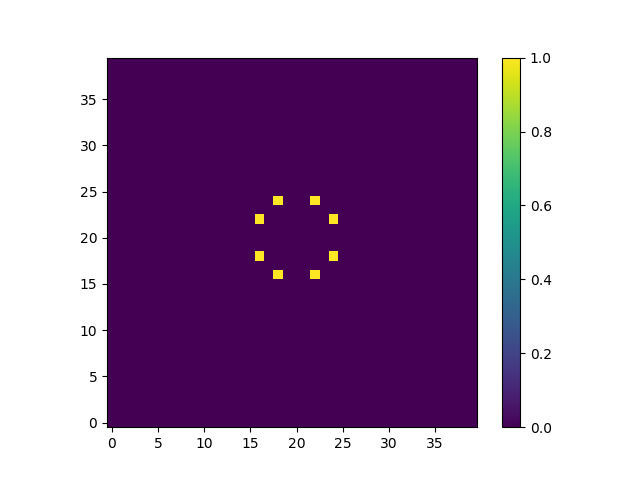

In [37]:
V=np.zeros((npix,npix),dtype=np.complex)
for i in range(npix):
    for j in range(npix):
        radius=(i-npix/2)**2/2 + (j-npix/2)**2/2
        if radius >= 10 and radius <=10:
            V[i,j]=1.

figure()
imshow(real(V),origin="lower")
colorbar()
        
Vall=np.kron(diag(V.ravel()),sigma0)
# figure()
# imshow(real(Vall),origin="lower")
# colorbar()

# $G=(\mathbb{1} -G_0V)^{-1}G_0$

In [38]:
I0=identity(2*npix**2,dtype=np.complex)
# G0V=np.matmul(G0all,Vall)
G0V=np.einsum("ij,jj->ij",G0all,Vall)
Gnew=np.linalg.solve(I0-G0V,G0all)

# LDOS $\rho(r)=\frac{-1}{\pi}Im G(r,r)$

In [44]:
a=[2,3]
if a:
    print "hello"
else:
    print "bye"

hello


In [39]:
ndos=-1*imag((np.diagonal(Gnew)[1::2] + np.diagonal(Gnew)[::2]).reshape(npix,npix))

<IPython.core.display.Javascript object>


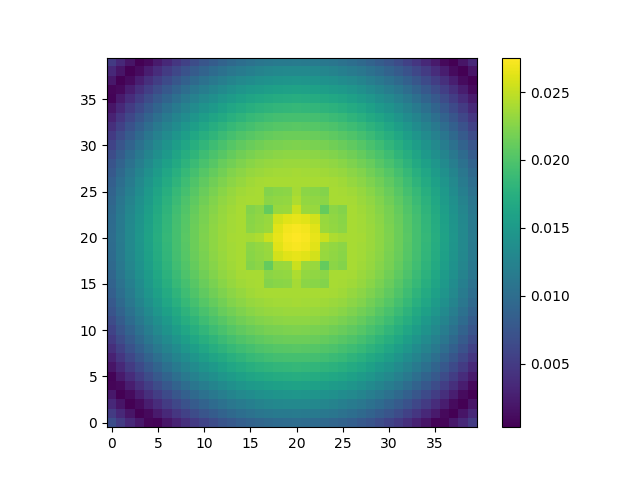

In [40]:
figure()
imshow(abs(ndos),origin="lower")
colorbar()

In [41]:
# vec=np.append([1.,1.],np.zeros(2*npix*npix-2))
# O=(sp.linalg.circulant(vec))[:npix**2,:]
# ndos=-1*imag(np.matmul(O,np.diagonal(Gnew))).reshape(npix,npix)
dos=-1*imag((np.diagonal(Gnew)[1::2] + np.diagonal(Gnew)[::2]).reshape(npix,npix))

O=np.kron(np.identity(npix*npix),(1+sigmax)/2.)
temp_Gnew=np.matmul(Gnew,O)
sdos_xp=-1*imag((np.diagonal(temp_Gnew)[1::2] + np.diagonal(temp_Gnew)[::2]).reshape(npix,npix))

# O=np.kron(np.identity(npix*npix),(1+sigmay)/2.)
# temp_Gnew=np.matmul(Gnew,O)
# sdos_yp=-1*imag((np.diagonal(temp_Gnew)[1::2] + np.diagonal(temp_Gnew)[::2]).reshape(npix,npix))

# O=np.kron(np.identity(npix*npix),(1+sigmaz)/2.)
# temp_Gnew=np.matmul(Gnew,O)
# sdos_zp=-1*imag((np.diagonal(temp_Gnew)[1::2] + np.diagonal(temp_Gnew)[::2]).reshape(npix,npix))

# O=np.kron(np.identity(npix*npix),(1-sigmax)/2.)
# temp_Gnew=np.matmul(Gnew,O)
# sdos_xm=-1*imag((np.diagonal(temp_Gnew)[1::2] + np.diagonal(temp_Gnew)[::2]).reshape(npix,npix))

# O=np.kron(np.identity(npix*npix),(1-sigmay)/2.)
# temp_Gnew=np.matmul(Gnew,O)
# sdos_ym=-1*imag((np.diagonal(temp_Gnew)[1::2] + np.diagonal(temp_Gnew)[::2]).reshape(npix,npix))

# O=np.kron(np.identity(npix*npix),(1-sigmaz)/2.)
# temp_Gnew=np.matmul(Gnew,O)
# sdos_zm=-1*imag((np.diagonal(temp_Gnew)[1::2] + np.diagonal(temp_Gnew)[::2]).reshape(npix,npix))

<IPython.core.display.Javascript object>


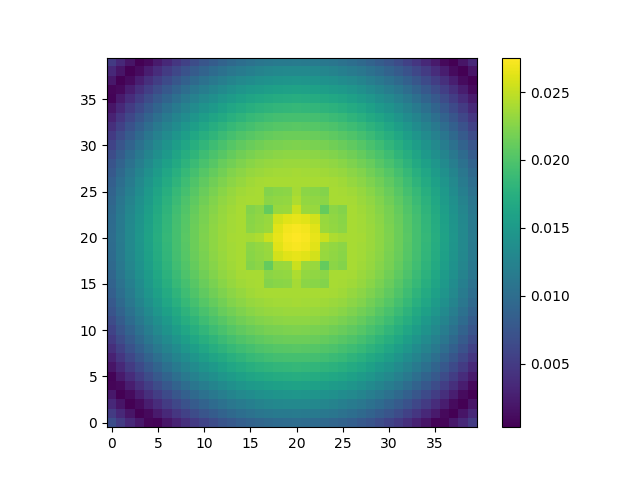

<IPython.core.display.Javascript object>


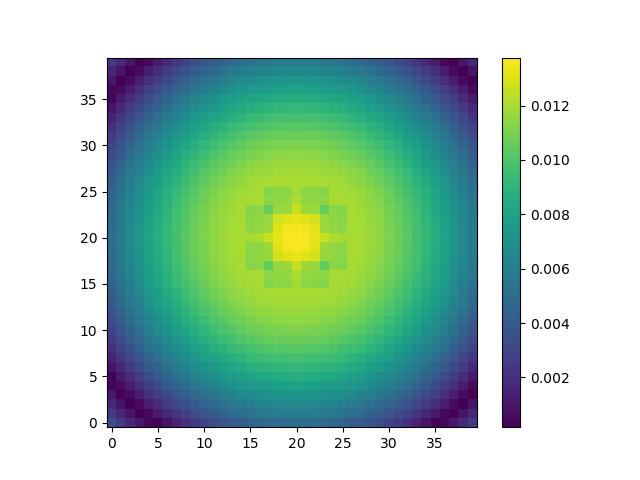

In [42]:
figure()
imshow(abs(dos),origin="lower")
colorbar()

figure()
imshow(abs(sdos_xp),origin="lower")
colorbar()

# figure()
# imshow(abs(sdos_xm),origin="lower")
# colorbar()

# figure()
# imshow(abs(sdos_yp),origin="lower")
# colorbar()

# figure()
# imshow(abs(sdos_ym),origin="lower")
# colorbar()

# figure()
# imshow(abs(sdos_zp),origin="lower")
# colorbar()

# figure()
# imshow(abs(sdos_zm),origin="lower")
# colorbar()

# Hexagonal potential

<IPython.core.display.Javascript object>


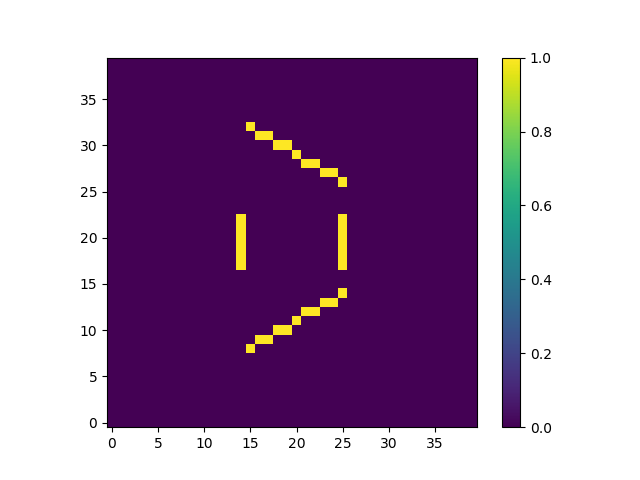

In [101]:
side=npix/6
ht=np.sqrt(3)*side
V=np.zeros((npix,npix),dtype=np.complex)
for i in range(npix):
    for j in range(npix):
        if i >=npix/2-side/2 and i <npix/2+side/2:
            j = np.int(npix/2-ht/2) 
            V[i,j]=1.
        if i >=npix/2-side/2 and i <npix/2+side/2:
            j = np.int(npix/2+ht/2) 
            V[i,j]=1.
        if j >=npix/2 and j <npix/2+ht/2:
            i=np.abs(np.int(j/np.sqrt(3)))
            V[i,j]=1.
        if j >=npix/2 and j <npix/2+ht/2:
            i=-np.abs(np.int(j/np.sqrt(3)))
            V[i,j]=1.
        if j >=npix/2-ht/2 and j <npix/2:
            i=-np.abs(np.int(j/np.sqrt(3)))
            V[i,j]=1.
        if j >=npix/2-ht/2 and j <npix/2+ht/2:
            i=np.abs(np.int(j/np.sqrt(3)))
            V[i,j]=1.
figure()
imshow(real(V),origin="lower")
colorbar()

<IPython.core.display.Javascript object>


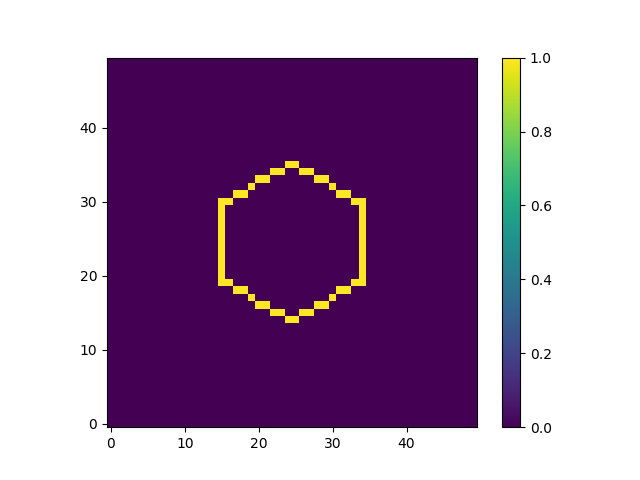

In [115]:
import itertools
npix=50
pad=0.05
x0=np.linspace(-1.,1.,npix)
y0=np.linspace(-1.,1.,npix)
cidx=[t for t in itertools.product(np.arange(npix),np.arange(npix))]
coord=[t for t in itertools.product(x0,y0)]


def hexagonal_well(V0=5,rad=1):
    V=np.zeros(npix**2,float)
    def hexagon(pos):
        s=x0[npix-int(np.ceil(pad*npix))]
        x, y = map(abs, pos)
        return y < 3**0.5 * min(s*rad - x, s*rad / 2)
    
    for i,xy in enumerate(coord):
        if not(hexagon(xy)):
            V[i]=1.
    V=V0*V/max(V)-V0
    return V
    
def return_2D_V(V0=5,rad=1):
    V=hexagonal_well(V0=V0,rad=rad)
    temp_V=np.zeros((npix,npix),float)
    for i,c in enumerate(cidx):
        temp_V[c]=V[i]
    return temp_V

V2d=return_2D_V(rad=0.5,V0=-1) - return_2D_V(rad=0.45,V0=-1)

figure()
imshow(V2d,origin="lower")
colorbar()

# Taylors method for G0all evaluations

In [246]:
r=linspace(0.1,20,1000)

In [207]:
from math import factorial
factorial(2)

2

In [211]:
def fn(x,a,a0,n):
    for i in range(n):
        (((a-a0)*x)**n /factorial(n))*jvp(0,a0*x,n=n)

In [247]:
f=lambda x,a,a0: jvp(0,a0*x,n=0) + (a-a0)*x*jvp(0,a0*x,n=1) + (0.5*((a-a0)*x)**2)*jvp(0,a0*x,n=2) + (((a-a0)*x)**3)*(1./6.)*jvp(0,a0*x,n=3) + (((a-a0)*x)**4)*(1./24.)*jvp(0,a0*x,n=4) + (((a-a0)*x)**5)*(1./120.)*jvp(0,a0*x,n=5) + (((a-a0)*x)**6)*(1./720.)*jvp(0,a0*x,n=6)

<IPython.core.display.Javascript object>


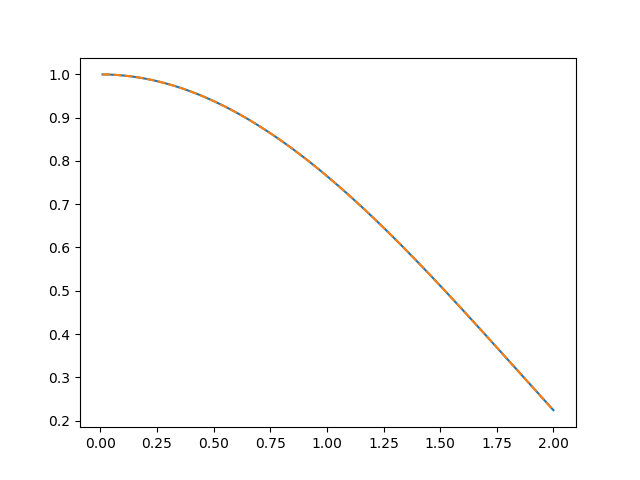

(0.18466680059507484, 1.0387992001353532)

In [251]:
a=0.1
xi=a*r

figure()
plot(xi,j0(xi))
plot(xi,f(r,a,0.03),"--")

ylim()

<IPython.core.display.Javascript object>


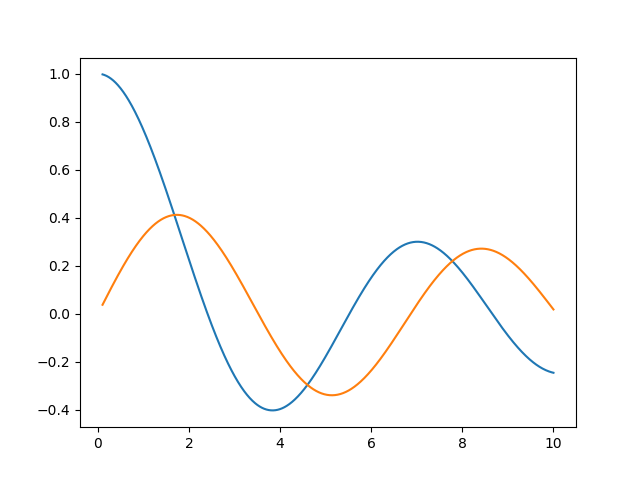

<IPython.core.display.Javascript object>


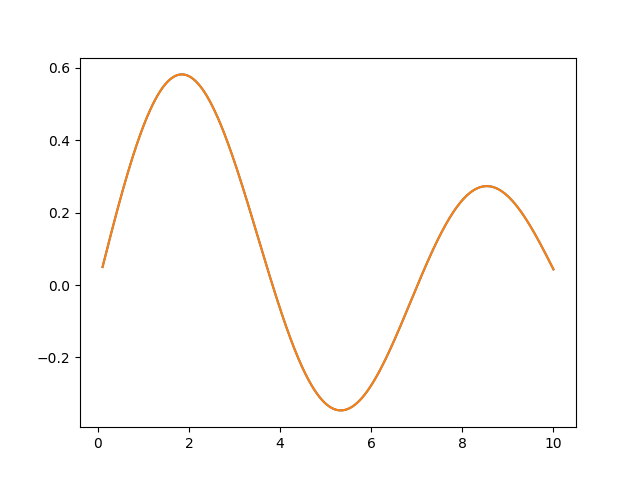

<IPython.core.display.Javascript object>


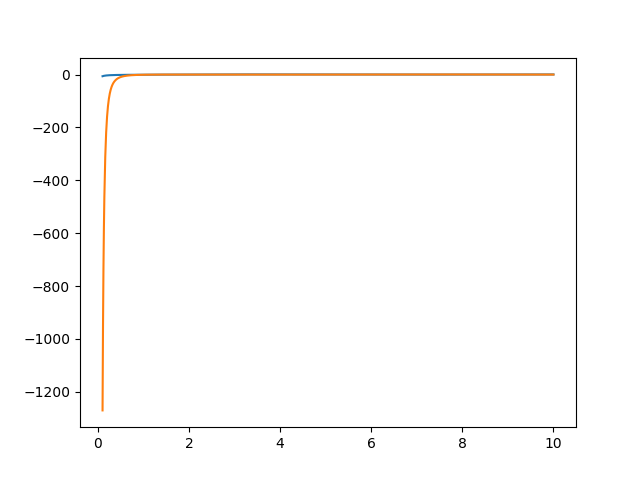

<IPython.core.display.Javascript object>


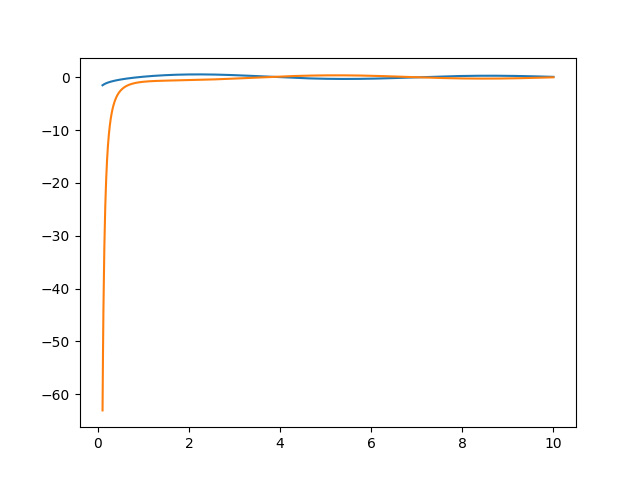

In [174]:
figure()
plot(r,j0(r))
plot(r,jvp(0,r,n=3))

figure()
plot(r,j1(r))
plot(r,jvp(1,r,n=0))

figure()
plot(r,y1(r))
plot(r,yvp(1,r,n=2))

figure()
plot(r,y0(r))
plot(r,yvp(0,r,n=2))